In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv("battedBallData.csv")
display(data)
data.isna().sum()

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307
1,366,405,ground_ball,60.098403,-54.652102,28.092203,-28.324082
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572
...,...,...,...,...,...,...,...
73370,241,144,ground_ball,88.608999,-18.897550,60.251389,-11.486760
73371,650,615,ground_ball,110.322436,-7.372974,106.029137,-7.702112
73372,267,615,fly_ball,85.887085,44.557649,83.302545,45.256039
73373,797,615,line_drive,81.857912,19.235941,78.979512,18.976781


batter         0
pitcher        0
hittype        0
speed_A     7572
vangle_A    7572
speed_B     1402
vangle_B    1402
dtype: int64

In [3]:
#data['batter_ID'] = data['batter'].astype('category')
#data['pitcher_ID'] = data['pitcher'].astype('category')

In [4]:
data.groupby("hittype").size()

hittype
U                  2
fly_ball       16722
ground_ball    33239
line_drive     18166
popup           5246
dtype: int64

### Uncertain what U means, delete it

In [5]:
print( data[data["hittype"] == "U"] )
data = data[data["hittype"] != "U"]
data.groupby("hittype").size()

       batter  pitcher hittype    speed_A   vangle_A    speed_B   vangle_B
25540     493      138       U  92.803315  24.403594  89.715655  24.082974
48326     479      228       U        NaN        NaN  60.520107 -22.862289


hittype
fly_ball       16722
ground_ball    33239
line_drive     18166
popup           5246
dtype: int64

In [6]:
for hittype in data['hittype'].unique():
    
    subset = data[data['hittype'] == hittype]

    Q1_A, Q3_A = subset['vangle_A'].quantile([0.25, 0.75])
    IQR_A = Q3_A - Q1_A

    Q1_B, Q3_B = subset['vangle_B'].quantile([0.25, 0.75])
    IQR_B = Q3_B - Q1_B

    lower_bound_A = Q1_A - 1.5 * IQR_A
    upper_bound_A = Q3_A + 1.5 * IQR_A
    outlier_condition_A = (subset['vangle_A'] < lower_bound_A) | (subset['vangle_A'] > upper_bound_A)

    lower_bound_B = Q1_B - 1.5 * IQR_B
    upper_bound_B = Q3_B + 1.5 * IQR_B
    outlier_condition_B = (subset['vangle_B'] < lower_bound_B) | (subset['vangle_B'] > upper_bound_B)

    data = data.drop(subset[(outlier_condition_A | outlier_condition_B)].index)

display(data)

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572
5,401,518,ground_ball,105.981831,-10.497794,78.508931,-7.471214
...,...,...,...,...,...,...,...
73370,241,144,ground_ball,88.608999,-18.897550,60.251389,-11.486760
73371,650,615,ground_ball,110.322436,-7.372974,106.029137,-7.702112
73372,267,615,fly_ball,85.887085,44.557649,83.302545,45.256039
73373,797,615,line_drive,81.857912,19.235941,78.979512,18.976781


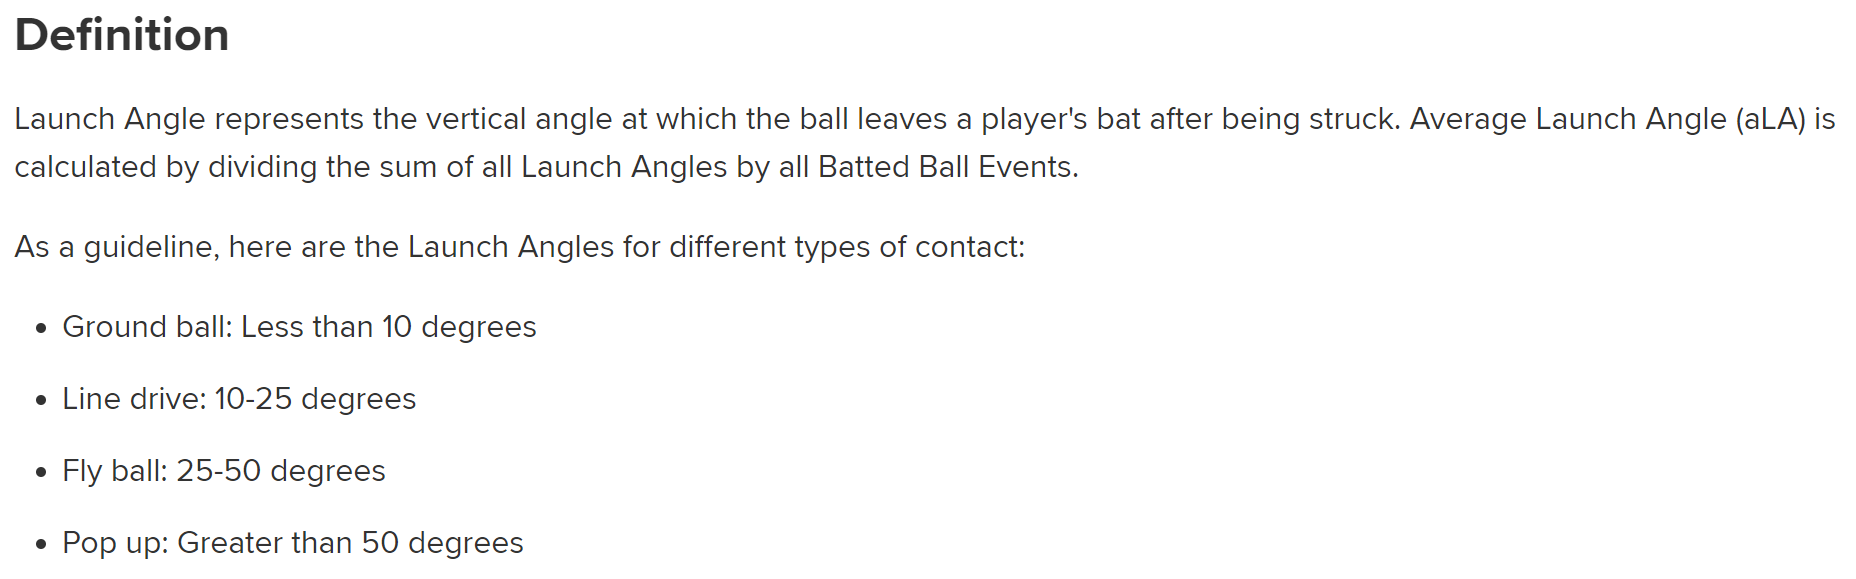
https://www.mlb.com/glossary/statcast/launch-angle

#### Change data to meet mlb official guideline

In [7]:
for index, row in data.iterrows():
    
    if not pd.isna(row["vangle_A"]):
        
        if row["vangle_A"] <= 10:
            row["hittype"] = "ground_ball"
        
        elif row["vangle_A"] > 10 and row["vangle_A"] <= 25:
            row["hittype"] = "line_drive"
            
        elif row["vangle_A"] > 25 and row["vangle_A"] <= 50:
            row["hittype"] = "fly_ball"
        
        elif row["vangle_A"] > 50:
            row["hittype"] = "pop_up"
        
    elif pd.isna(row["vangle_A"]) and not pd.isna(row["vangle_B"]):
        
        if row["vangle_B"] <= 10:
            row["hittype"] = "ground_ball"
        
        elif row["vangle_B"] > 10 and row["vangle_B"] <= 25:
            row["hittype"] = "line_drive"
            
        elif row["vangle_B"] > 25 and row["vangle_B"] <= 50:
            row["hittype"] = "fly_ball"
        
        elif row["vangle_B"] > 50:
            row["hittype"] = "pop_up"
            
            
data_clean = data[pd.notna(data["vangle_A"]) | pd.notna(data["vangle_B"])]     
display(data_clean)
data_clean.isna().sum()

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572
5,401,518,ground_ball,105.981831,-10.497794,78.508931,-7.471214
...,...,...,...,...,...,...,...
73370,241,144,ground_ball,88.608999,-18.897550,60.251389,-11.486760
73371,650,615,ground_ball,110.322436,-7.372974,106.029137,-7.702112
73372,267,615,fly_ball,85.887085,44.557649,83.302545,45.256039
73373,797,615,line_drive,81.857912,19.235941,78.979512,18.976781


batter         0
pitcher        0
hittype        0
speed_A     5997
vangle_A    5997
speed_B      804
vangle_B     804
dtype: int64

In [8]:
data_clean.groupby("hittype").size()

hittype
fly_ball       16682
ground_ball    30947
line_drive     18066
popup           4905
dtype: int64

In [9]:
data_clean_A = data_clean[pd.notna(data_clean["vangle_A"])]
data_clean_A = data_clean_A.drop(["speed_B","vangle_B"], axis = 1)
data_clean_B = data_clean[pd.notna(data_clean["vangle_B"])]  
data_clean_B = data_clean_B.drop(["speed_A","vangle_A"], axis = 1)

#### Bootstrapping

Measure A

In [10]:
# Filter batters who have at least 30 data
batter_counts_A = data_clean_A['batter'].value_counts()
batter_atleast30_A = batter_counts_A[batter_counts_A >= 30].index

# Filter the original DataFrame for these batters
data_clean_A_filtered = data_clean_A[data_clean_A['batter'].isin(batter_atleast30_A)]

In [11]:
display(data_clean_A_filtered)
data_clean_A_filtered.groupby("hittype").size()

,batter,pitcher,hittype,speed_A,vangle_A
0,393,405,ground_ball,110.987569,4.194081
2,448,518,line_drive,102.757602,11.751851
3,140,518,fly_ball,61.952091,33.488154
5,401,518,ground_ball,105.981831,-10.497794
6,184,405,ground_ball,87.746939,-22.605695
...,...,...,...,...,...
73369,541,144,ground_ball,89.707804,-2.206624
73370,241,144,ground_ball,88.608999,-18.897550
73372,267,615,fly_ball,85.887085,44.557649
73373,797,615,line_drive,81.857912,19.235941


hittype
fly_ball       15662
ground_ball    26000
line_drive     16973
popup           2529
dtype: int64

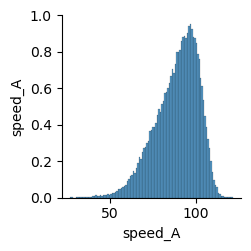

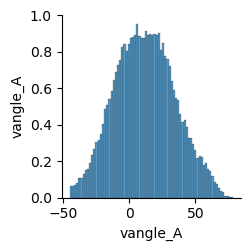

In [12]:
# initial
sns.pairplot(data_clean_A_filtered[['speed_A']])
sns.pairplot(data_clean_A_filtered[['vangle_A']])

In [13]:
max_batter_count_A = data_clean_A_filtered['batter'].value_counts().max()
print(max_batter_count_A)

421


In [17]:
bootstrapped_data_A = pd.DataFrame()

for batter, count in data_clean_A_filtered['batter'].value_counts().items():
    if count < max_batter_count_A:
        batter_data_A = data_clean_A[data_clean_A['batter'] == batter]
        add_data_A = resample(batter_data_A, replace=True, 
                                  n_samples = max_batter_count_A - count, 
                                  random_state = 1)
        bootstrapped_data_A = pd.concat([bootstrapped_data_A, add_data_A], ignore_index = True)

final_data_A = pd.concat([data_clean_A_filtered, bootstrapped_data_A], ignore_index = True)
final_data_A.groupby("batter").size()

batter
1      421
4      421
5      421
6      421
7      421
      ... 
806    421
808    421
810    421
811    421
812    421
Length: 430, dtype: int64

In [18]:
final_data_A

,batter,pitcher,hittype,speed_A,vangle_A
0,393,405,ground_ball,110.987569,4.194081
1,448,518,line_drive,102.757602,11.751851
2,140,518,fly_ball,61.952091,33.488154
3,401,518,ground_ball,105.981831,-10.497794
4,184,405,ground_ball,87.746939,-22.605695
...,...,...,...,...,...
181025,404,68,ground_ball,99.539883,1.960857
181026,404,606,ground_ball,99.981320,7.005473
181027,404,606,line_drive,98.062394,21.061144
181028,404,68,ground_ball,99.539883,1.960857


In [19]:
final_data_A.groupby("hittype").size()

hittype
fly_ball       46297
ground_ball    77719
line_drive     49372
popup           7642
dtype: int64

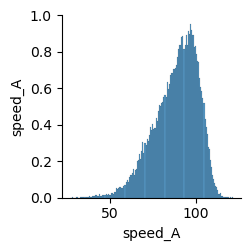

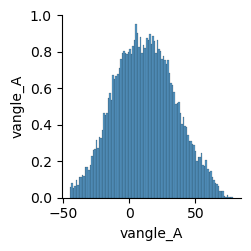

In [20]:
sns.pairplot(final_data_A[['speed_A']])
sns.pairplot(final_data_A[['vangle_A']])

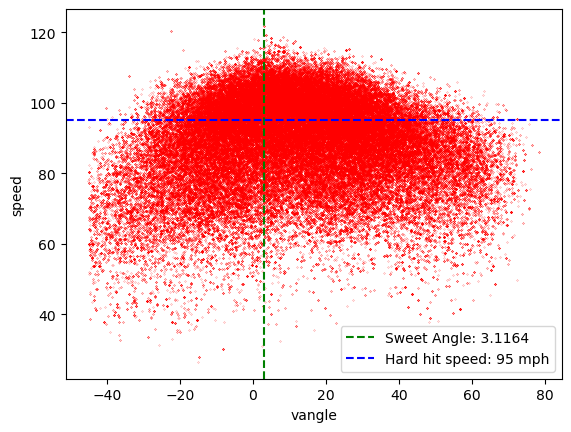

In [53]:
# BEFORE BOOTSTRAPPING
speed_per_angle_A = data_clean_A_filtered.groupby("vangle_A")["speed_A"].median()
best_angle_A = round( speed_per_angle_A.idxmax(), 4)

hard_hit_speed = 95 #Statcast defines a 'hard-hit ball' as one hit with an exit velocity of 95 mph or higher

## Scatter Plot: Angle x Speed
plt.scatter(final_data_A["vangle_A"], final_data_A["speed_A"], s=.1,c='r', marker= '.')
plt.axvline(best_angle_A, label = "Sweet Angle: " + str(best_angle_A), color='g', linestyle='--')
plt.axhline(95, label="Hard hit speed: 95 mph", color='b', linestyle='--')
plt.xlabel('vangle')
plt.ylabel('speed')
plt.legend()
plt.show()

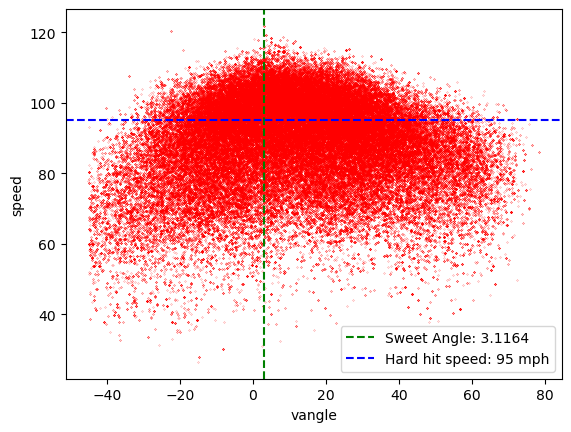

In [54]:
speed_per_angle_A = final_data_A.groupby("vangle_A")["speed_A"].median()
best_angle_A = round( speed_per_angle_A.idxmax(), 4)

hard_hit_speed = 95 #Statcast defines a 'hard-hit ball' as one hit with an exit velocity of 95 mph or higher

## Scatter Plot: Angle x Speed
plt.scatter(final_data_A["vangle_A"], final_data_A["speed_A"], s=.1,c='r', marker= '.')
plt.axvline(best_angle_A, label = "Sweet Angle: " + str(best_angle_A), color='g', linestyle='--')
plt.axhline(95, label="Hard hit speed: 95 mph", color='b', linestyle='--')
plt.xlabel('vangle')
plt.ylabel('speed')
plt.legend()
plt.show()


Measure B

In [22]:
# Filter batters who have at least 30 data
batter_counts_B = data_clean_B['batter'].value_counts()
batter_atleast30_B = batter_counts_B[batter_counts_B >= 30].index

# Filter the original DataFrame for these batters
data_clean_B_filtered = data_clean_B[data_clean_B['batter'].isin(batter_atleast30_B)]

max_batter_count_B = data_clean_B_filtered['batter'].value_counts().max()
print(max_batter_count_B)

bootstrapped_data_B = pd.DataFrame()

for batter, count in data_clean_B_filtered['batter'].value_counts().items():
    if count < max_batter_count_B:
        batter_data_B = data_clean_B[data_clean_B['batter'] == batter]
        add_data_B = resample(batter_data_B, replace=True, 
                                  n_samples = max_batter_count_B - count, 
                                  random_state = 1)
        bootstrapped_data_B = pd.concat([bootstrapped_data_B, add_data_B], ignore_index = True)

final_data_B = pd.concat([data_clean_B_filtered, bootstrapped_data_B], ignore_index = True)
final_data_B.groupby("batter").size()

465


batter
1      465
4      465
5      465
6      465
7      465
      ... 
806    465
808    465
810    465
811    465
812    465
Length: 442, dtype: int64

In [23]:
display(data_clean_B_filtered)
data_clean_B_filtered.groupby("hittype").size()

,batter,pitcher,hittype,speed_B,vangle_B
0,393,405,ground_ball,103.842569,3.164307
2,448,518,line_drive,97.846002,11.658800
3,140,518,fly_ball,59.389741,32.798274
5,401,518,ground_ball,78.508931,-7.471214
6,184,405,ground_ball,62.273449,-12.718385
...,...,...,...,...,...
73370,241,144,ground_ball,60.251389,-11.486760
73371,650,615,ground_ball,106.029137,-7.702112
73372,267,615,fly_ball,83.302545,45.256039
73373,797,615,line_drive,78.979512,18.976781


hittype
fly_ball       15787
ground_ball    28897
line_drive     17172
popup           4546
dtype: int64

In [24]:
display(final_data_B)
final_data_B.groupby("hittype").size()

,batter,pitcher,hittype,speed_B,vangle_B
0,393,405,ground_ball,103.842569,3.164307
1,448,518,line_drive,97.846002,11.658800
2,140,518,fly_ball,59.389741,32.798274
3,401,518,ground_ball,78.508931,-7.471214
4,184,405,ground_ball,62.273449,-12.718385
...,...,...,...,...,...
205525,575,212,popup,71.515702,59.495638
205526,575,240,popup,80.596570,76.523357
205527,575,172,ground_ball,85.369649,-5.677953
205528,575,212,fly_ball,98.194287,21.079496


hittype
fly_ball       48809
ground_ball    90161
line_drive     52251
popup          14309
dtype: int64

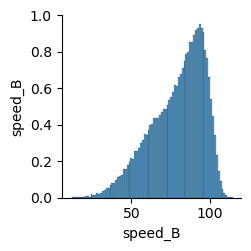

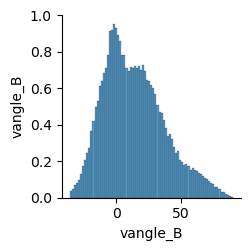

In [25]:
# initial B
sns.pairplot(data_clean_B_filtered[['speed_B']])
sns.pairplot(data_clean_B_filtered[['vangle_B']])

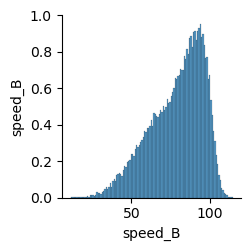

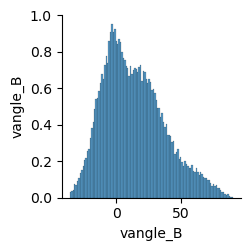

In [26]:
sns.pairplot(final_data_B[['speed_B']])
sns.pairplot(final_data_B[['vangle_B']])

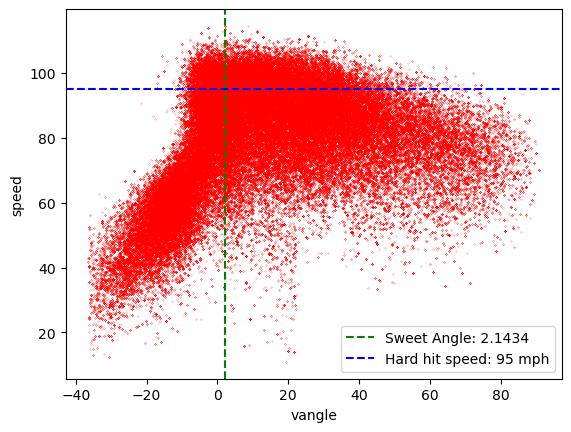

In [55]:
# BEFORE BOOTSTRAPPING
speed_per_angle_B = data_clean_B_filtered.groupby("vangle_B")["speed_B"].median()
best_angle_B = round( speed_per_angle_B.idxmax(), 4)

hard_hit_speed = 95 #Statcast defines a 'hard-hit ball' as one hit with an exit velocity of 95 mph or higher

## Scatter Plot: Angle x Speed
plt.scatter(final_data_B["vangle_B"], final_data_B["speed_B"], s=.1,c='r', marker= '.')
plt.axvline(best_angle_B, label = "Sweet Angle: " + str(best_angle_B), color='g', linestyle='--')
plt.axhline(95, label="Hard hit speed: 95 mph", color='b', linestyle='--')
plt.xlabel('vangle')
plt.ylabel('speed')
plt.legend()
plt.show()

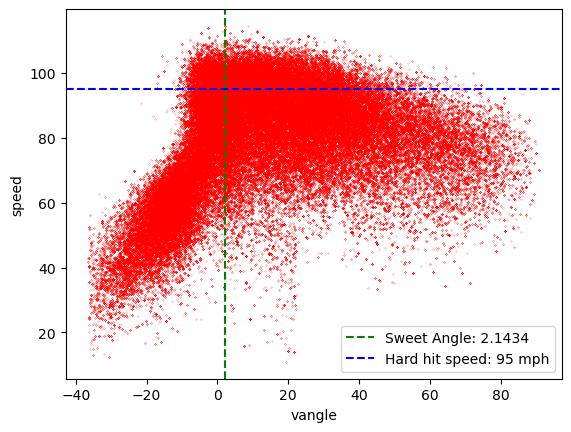

In [56]:
speed_per_angle_B = final_data_B.groupby("vangle_B")["speed_B"].median()
best_angle_B = round( speed_per_angle_B.idxmax(), 4)

hard_hit_speed = 95 #Statcast defines a 'hard-hit ball' as one hit with an exit velocity of 95 mph or higher

## Scatter Plot: Angle x Speed
plt.scatter(final_data_B["vangle_B"], final_data_B["speed_B"], s=.1,c='r', marker= '.')
plt.axvline(best_angle_B, label = "Sweet Angle: " + str(best_angle_B), color='g', linestyle='--')
plt.axhline(95, label="Hard hit speed: 95 mph", color='b', linestyle='--')
plt.xlabel('vangle')
plt.ylabel('speed')
plt.legend()
plt.show()

### Linear |Angle - Sweet Angle|

Measure A

In [28]:
# absolute angle difference
data_clean_A_filtered["abs_angle_diff"] = (data_clean_A_filtered["vangle_A"] - best_angle_A).abs()   
data_clean_A_filtered["abs_angle_diff"]

C:\Users\hsupo\AppData\Local\Temp\ipykernel_33760\1211642338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_A_filtered["abs_angle_diff"] = (data_clean_A_filtered["vangle_A"] - best_angle_A).abs()


0         1.077681
2         8.635451
3        30.371754
5        13.614194
6        25.722095
           ...    
73369     5.323024
73370    22.013950
73372    41.441249
73373    16.119541
73374    13.228820
Name: abs_angle_diff, Length: 61164, dtype: float64

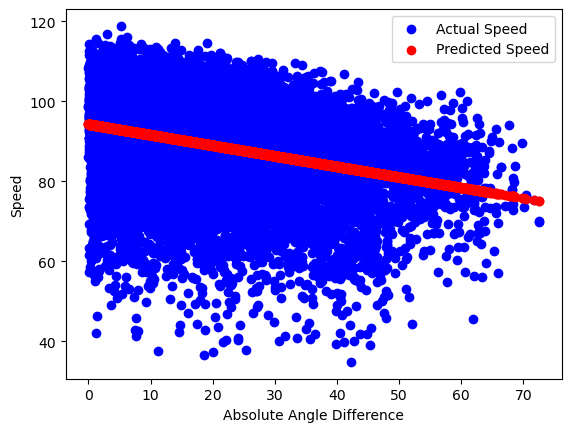

Model R-squared score: 0.09434093934423482
Mean Absolute Error: 9.65439127302667
Mean Squared Error: 145.70905936867868


In [29]:
batter_speed_performance_linear = {}


x_linear_A = data_clean_A_filtered[["abs_angle_diff"]]  # Predictor
y_linear_A = data_clean_A_filtered['speed_A']     # Response


x_train, x_test, y_train, y_test = train_test_split(x_linear_A, y_linear_A, test_size=0.2, random_state=42)

linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)

linear_predictions = linear_regression.predict(x_test)

# Plotting the results
plt.scatter(x_test, y_test, color='blue', label='Actual Speed')
plt.scatter(x_test, linear_predictions, color='red', label='Predicted Speed')
plt.xlabel('Absolute Angle Difference')
plt.ylabel('Speed')
plt.legend()
plt.show()

# Calculate error metrics
mae = metrics.mean_absolute_error(y_test, linear_predictions)
mse = metrics.mean_squared_error(y_test, linear_predictions)
r_square = r2_score(y_test,linear_predictions)

print(f"Model R-squared score: {r_square}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Measure B

C:\Users\hsupo\AppData\Local\Temp\ipykernel_33760\787917531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_B_filtered["abs_angle_diff"] = (data_clean_B_filtered["vangle_B"] - best_angle_B).abs()


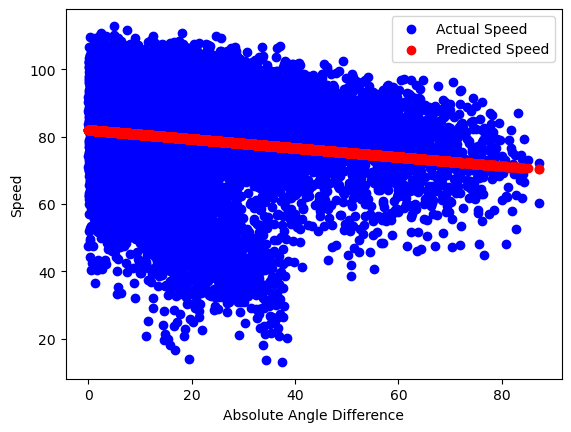

Model R-squared score: 0.01810156254553208
Mean Absolute Error: 13.760789859510957
Mean Squared Error: 277.58405664109017


In [30]:
# absolute angle difference
data_clean_B_filtered["abs_angle_diff"] = (data_clean_B_filtered["vangle_B"] - best_angle_B).abs()   
data_clean_B_filtered["abs_angle_diff"]

batter_speed_performance_linear = {}


x_linear_B = data_clean_B_filtered[["abs_angle_diff"]]  # Predictor
y_linear_B = data_clean_B_filtered['speed_B']     # Response


x_train, x_test, y_train, y_test = train_test_split(x_linear_B, y_linear_B, test_size=0.2, random_state=42)

linear_regression_B = LinearRegression()
linear_regression_B.fit(x_train, y_train)

linear_predictions_B = linear_regression_B.predict(x_test)

# Plotting the results
plt.scatter(x_test, y_test, color='blue', label='Actual Speed')
plt.scatter(x_test, linear_predictions_B, color='red', label='Predicted Speed')
plt.xlabel('Absolute Angle Difference')
plt.ylabel('Speed')
plt.legend()
plt.show()

# Calculate error metrics
mae = metrics.mean_absolute_error(y_test, linear_predictions_B)
mse = metrics.mean_squared_error(y_test, linear_predictions_B)
r_square = r2_score(y_test,linear_predictions_B)

print(f"Model R-squared score: {r_square}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

### Random Forest

Measure A

In [31]:
# Assuming final_data_A is already loaded and contains 'vangle_A' and 'speed_A'
x_rf = final_data_A[['vangle_A']]  # Predictor - vangle_A
y_rf = final_data_A['speed_A']     # Response - speed_A

# Split the data into training and test sets
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train_rf, y_train_rf)

# Predict on the test set
rf_predictions = rf_model.predict(x_test_rf)

# R squared
rf_r2 = r2_score(y_test_rf, rf_predictions)

# Calculate error metrics
rf_mae = metrics.mean_absolute_error(y_test_rf, rf_predictions)
rf_mse = metrics.mean_squared_error(y_test_rf, rf_predictions)

print(f"Model R-squared score: {rf_r2}")
print(f"Mean Absolute Error: {rf_mae}")
print(f"Mean Squared Error: {rf_mse}")

Model R-squared score: 0.7374251674945762
Mean Absolute Error: 3.0200855396900868
Mean Squared Error: 42.224437540112255


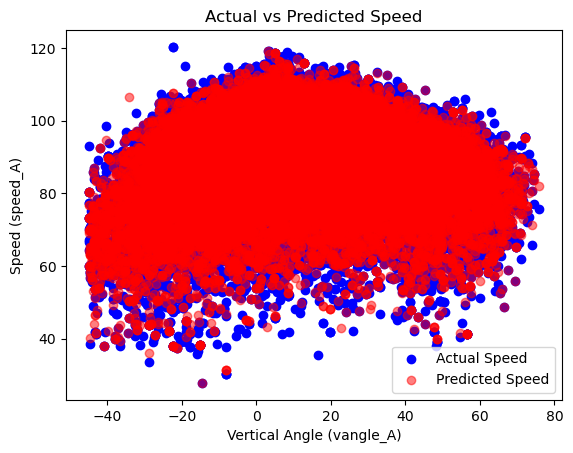

In [33]:
plt.scatter(x_test_rf, y_test_rf, color='blue', label='Actual Speed')
plt.scatter(x_test_rf, rf_predictions, color='red', label='Predicted Speed', alpha=0.5)
plt.title('Actual vs Predicted Speed')
plt.xlabel('Vertical Angle (vangle_A)')
plt.ylabel('Speed (speed_A)')
plt.legend()
plt.show()

Measure B

In [34]:
x_rf = final_data_B[['vangle_B']]  # Predictor - vangle_B
y_rf = final_data_B['speed_B']     # Response - speed_B

# Split the data into training and test sets
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model_B = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_B.fit(x_train_rf, y_train_rf)

# Predict on the test set
rf_predictions_B = rf_model_B.predict(x_test_rf)

# R squared
rf_r2_B = r2_score(y_test_rf, rf_predictions_B)

# Calculate error metrics
rf_mae_B = metrics.mean_absolute_error(y_test_rf, rf_predictions_B)
rf_mse_B = metrics.mean_squared_error(y_test_rf, rf_predictions_B)

print(f"Model R-squared score: {rf_r2_B}")
print(f"Mean Absolute Error: {rf_mae_B}")
print(f"Mean Squared Error: {rf_mse_B}")

Model R-squared score: 0.8625770094440781
Mean Absolute Error: 2.8450516042809664
Mean Squared Error: 39.75458278202162


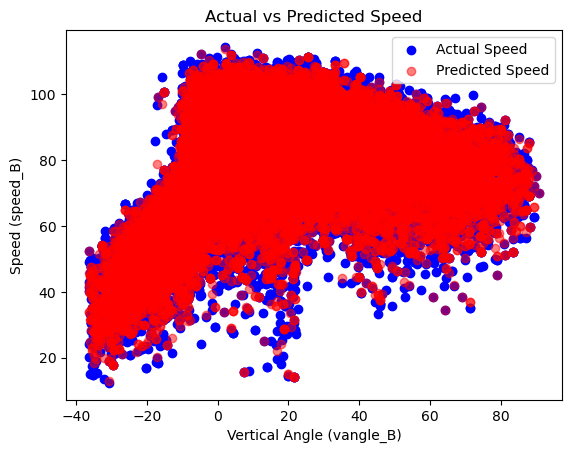

In [35]:
plt.scatter(x_test_rf, y_test_rf, color='blue', label='Actual Speed')
plt.scatter(x_test_rf, rf_predictions_B, color='red', label='Predicted Speed', alpha=0.5)
plt.title('Actual vs Predicted Speed')
plt.xlabel('Vertical Angle (vangle_B)')
plt.ylabel('Speed (speed_B)')
plt.legend()
plt.show()

### Neural Network

Measure A

In [37]:
x_nn = final_data_A[["vangle_A"]].values  # Features - Vertical Angle
y_nn = final_data_A["speed_A"].values     # Target - Speed

x_train, x_test, y_train, y_test = train_test_split(x_nn, y_nn, test_size=0.2, random_state=42)

# Scale the features -> to ensure that all feature variables contribute evenly to the model's training, 
# which can speed up the learning process and enhance model performance
scaler_A = StandardScaler()
x_train_scaled = scaler_A.fit_transform(x_train)
x_test_scaled = scaler_A.transform(x_test)

# Initialize the MLPRegressor
mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(100,),  
    activation='relu', 
    solver='adam', 
    max_iter=1000,
    learning_rate_init=0.001,
    alpha=0.0001,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

mlp_regressor.fit(x_train_scaled, y_train)

nn_predictions = mlp_regressor.predict(x_test_scaled)

nn_r2 = r2_score(y_test, nn_predictions)
nn_mae = metrics.mean_absolute_error(y_test, nn_predictions)
nn_mse = metrics.mean_squared_error(y_test, nn_predictions)

print(f"Model R-squared score: {nn_r2}")
print(f"Mean Absolute Error: {nn_mae}")
print(f"Mean Squared Error: {nn_mse}")

Model R-squared score: 0.1533872698096843
Mean Absolute Error: 9.308674791808386
Mean Squared Error: 136.14307969080195


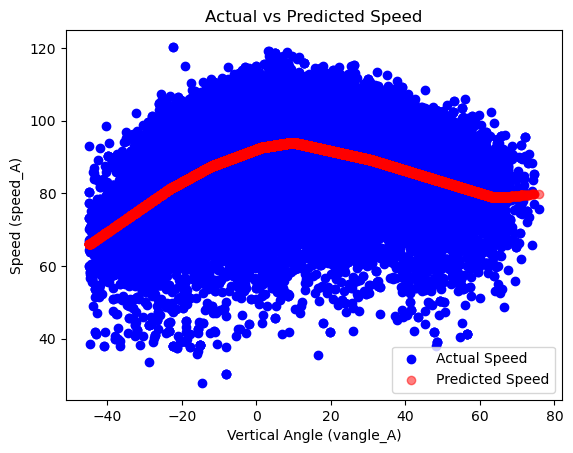

In [38]:
plt.scatter(x_test, y_test, color='blue', label='Actual Speed')
plt.scatter(x_test, nn_predictions, color='red', label='Predicted Speed', alpha=0.5)
plt.title('Actual vs Predicted Speed')
plt.xlabel('Vertical Angle (vangle_A)')
plt.ylabel('Speed (speed_A)')
plt.legend()
plt.show()

Measure B

In [39]:
x_nn = final_data_B[["vangle_B"]].values  # Features - Vertical Angle
y_nn = final_data_B["speed_B"].values     # Target - Speed

x_train, x_test, y_train, y_test = train_test_split(x_nn, y_nn, test_size=0.2, random_state=42)

# Scale the features -> to ensure that all feature variables contribute evenly to the model's training, 
# which can speed up the learning process and enhance model performance
scaler_B = StandardScaler()
x_train_scaled = scaler_B.fit_transform(x_train)
x_test_scaled = scaler_B.transform(x_test)

# Initialize the MLPRegressor
mlp_regressor_B = MLPRegressor(
    hidden_layer_sizes=(100,),  
    activation='relu', 
    solver='adam', 
    max_iter=1000,
    learning_rate_init=0.001,
    alpha=0.0001,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

mlp_regressor_B.fit(x_train_scaled, y_train)

nn_predictions_B = mlp_regressor_B.predict(x_test_scaled)

nn_r2_B = r2_score(y_test, nn_predictions_B)

nn_mae = metrics.mean_absolute_error(y_test, nn_predictions_B)
nn_mse = metrics.mean_squared_error(y_test, nn_predictions_B)

print(f"Model R-squared score: {nn_r2_B}")
print(f"Mean Absolute Error: {nn_mae}")
print(f"Mean Squared Error: {nn_mse}")

Model R-squared score: 0.5187816689827609
Mean Absolute Error: 9.239135244231083
Mean Squared Error: 139.20985054437625


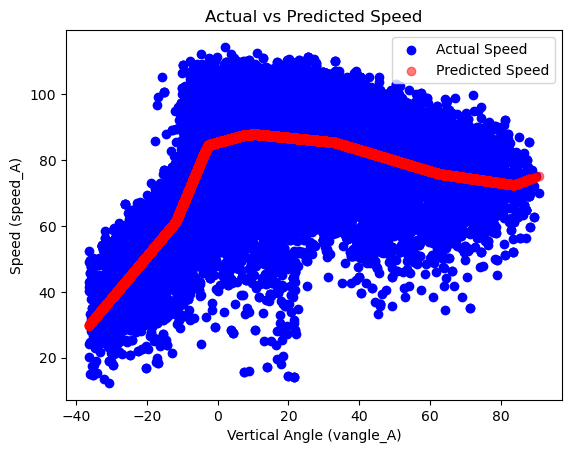

In [40]:
plt.scatter(x_test, y_test, color='blue', label='Actual Speed')
plt.scatter(x_test, nn_predictions_B, color='red', label='Predicted Speed', alpha=0.5)
plt.title('Actual vs Predicted Speed')
plt.xlabel('Vertical Angle (vangle_A)')
plt.ylabel('Speed (speed_A)')
plt.legend()
plt.show()

### Posterior Mean - Speed

Measure A

In [41]:
prior_mean = final_data_A["speed_A"].mean()
prior_var = final_data_A["speed_A"].var()

batter_ids = final_data_A['batter'].unique()

batter_speed_performance_A = {}
for batter_id in batter_ids:
    batter_data = final_data_A[final_data_A["batter"] == batter_id]
    
    sample_mean = batter_data["speed_A"].mean()
    sample_size = max_batter_count_A
    sample_var = batter_data["speed_A"].var()
    posterior_mean = (prior_mean/prior_var + sample_mean*sample_size/sample_var ) / (1/prior_var + sample_size/sample_var)
    batter_speed_performance_A[batter_id] = posterior_mean

batter_speed_performance_A = dict(sorted(batter_speed_performance_A.items()))
batter_speed_performance_A = pd.DataFrame(batter_speed_performance_A.items(), columns = ["batter", "speed_A"])
batter_speed_performance_A

,batter,speed_A
0,1,89.636034
1,4,89.899964
2,5,89.558691
3,6,85.167970
4,7,89.928166
...,...,...
425,806,86.045302
426,808,83.273675
427,810,88.121202
428,811,94.616309


Measure B

In [42]:
prior_mean = final_data_B["speed_B"].mean()
prior_var = final_data_B["speed_B"].var()

batter_ids = final_data_B['batter'].unique()

batter_speed_performance_B = {}
for batter_id in batter_ids:
    batter_data = final_data_B[final_data_B["batter"] == batter_id]
    
    sample_mean = batter_data["speed_B"].mean()
    sample_size = max_batter_count_B
    sample_var = batter_data["speed_B"].var()
    posterior_mean = (prior_mean/prior_var + sample_mean*sample_size/sample_var ) / (1/prior_var + sample_size/sample_var)
    batter_speed_performance_B[batter_id] = posterior_mean

batter_speed_performance_B = dict(sorted(batter_speed_performance_B.items()))
batter_speed_performance_B = pd.DataFrame(batter_speed_performance_B.items(), columns = ["batter", "speed_B"])
batter_speed_performance_B

,batter,speed_B
0,1,77.603179
1,4,78.846093
2,5,80.240595
3,6,72.452534
4,7,83.142554
...,...,...
437,806,76.042990
438,808,77.459119
439,810,79.015539
440,811,80.304977


### Posterior Mean - vangle

Measure A

In [43]:
prior_mean_va = final_data_A["vangle_A"].mean()
prior_var_va = final_data_A["vangle_A"].var()

batter_ids = final_data_A['batter'].unique()

batter_angle_performance_A = {}
for batter_id in batter_ids:
    batter_data = final_data_A[final_data_A["batter"] == batter_id]
    
    sample_mean = batter_data["vangle_A"].mean()
    sample_size = max_batter_count_A
    sample_var = batter_data["vangle_A"].var()
    posterior_mean = (prior_mean_va/prior_var_va + sample_mean*sample_size/sample_var ) / (1/prior_var_va + sample_size/sample_var)
    batter_angle_performance_A[batter_id] = posterior_mean

batter_angle_performance_A = dict(sorted(batter_angle_performance_A.items()))
batter_angle_performance_A = pd.DataFrame(batter_angle_performance_A.items(), columns = ["batter", "vangle_A"])
batter_angle_performance_A

,batter,vangle_A
0,1,11.154251
1,4,11.549089
2,5,11.729888
3,6,3.074671
4,7,21.454689
...,...,...
425,806,6.709671
426,808,13.559242
427,810,8.614633
428,811,12.829123


Measure B

In [44]:
prior_mean_va = final_data_B["vangle_B"].mean()
prior_var_va = final_data_B["vangle_B"].var()

batter_ids = final_data_B['batter'].unique()

batter_angle_performance_B = {}
for batter_id in batter_ids:
    batter_data = final_data_B[final_data_B["batter"] == batter_id]
    
    sample_mean = batter_data["vangle_B"].mean()
    sample_size = max_batter_count_B
    sample_var = batter_data["vangle_B"].var()
    posterior_mean = (prior_mean_va/prior_var_va + sample_mean*sample_size/sample_var ) / (1/prior_var_va + sample_size/sample_var)
    batter_angle_performance_B[batter_id] = posterior_mean

batter_angle_performance_B = dict(sorted(batter_angle_performance_B.items()))
batter_angle_performance_B = pd.DataFrame(batter_angle_performance_B.items(), columns = ["batter", "vangle_B"])
batter_angle_performance_B

,batter,vangle_B
0,1,10.438277
1,4,13.165263
2,5,14.504040
3,6,5.189794
4,7,19.359331
...,...,...
437,806,9.458085
438,808,16.478092
439,810,8.201420
440,811,10.218355


### Predicted Speed Result

In [45]:
def predicted_player_speed( batter_ID ):

    if batter_ID in final_data_A["batter"].values:
        
        print("Batter " + str(batter_ID) + " is predicted based on Measure A")
        
        batter_speed_A = batter_speed_performance_A.loc[batter_speed_performance_A["batter"] == batter_ID, "speed_A"].mean()
        print(f"Prior Mean predicted speed: {batter_speed_A}")

        batter_predicted_angle = batter_angle_performance_A.loc[batter_angle_performance_A["batter"] == batter_ID, "vangle_A"].values.reshape(-1, 1)

        linear_predictions = linear_regression.predict( batter_predicted_angle )
        print(f"Linear Regression predicted speed: {linear_predictions[0]}")

        rf_predictions = rf_model.predict(batter_predicted_angle)
        print(f"Random Forest predicted speed: {rf_predictions[0]}")

        nn_predictions = mlp_regressor.predict(scaler_A.transform(batter_predicted_angle))
        print(f"Neural Network predicted speed: {nn_predictions[0]}")
    
    elif batter_ID in final_data_B["batter"].values:
        
        print("Batter " + str(batter_ID) + " is predicted based on Measure B")
        
        batter_speed_B = batter_speed_performance_B.loc[batter_speed_performance_B["batter"] == batter_ID, "speed_B"].mean()
        print(f"Prior Mean predicted speed: {batter_speed_B}")

        batter_predicted_angle_B = batter_angle_performance_B.loc[batter_angle_performance_B["batter"] == batter_ID, "vangle_B"].values.reshape(-1, 1)

        linear_predictions_B = linear_regression_B.predict( batter_predicted_angle_B )
        print(f"Linear Regression predicted speed: {linear_predictions_B[0]}")

        rf_predictions_B = rf_model_B.predict(batter_predicted_angle_B)
        print(f"Random Forest predicted speed: {rf_predictions_B[0]}")

        nn_predictions_B = mlp_regressor_B.predict(scaler_B.transform(batter_predicted_angle_B))
        print(f"Neural Network predicted speed: {nn_predictions_B[0]}")
        
    else:
        print( "Batter " + str(batter_ID) + " has no enough data in the previous record.")        

In [46]:
for i in range(30):
    predicted_player_speed( i + 1 )

Batter 1 is predicted based on Measure A
Prior Mean predicted speed: 89.63603376166832
Linear Regression predicted speed: 91.30507485414023
Random Forest predicted speed: 94.89607434420004
Neural Network predicted speed: 93.63202095582605
Batter 2 has no enough data in the previous record.
Batter 3 has no enough data in the previous record.
Batter 4 is predicted based on Measure A
Prior Mean predicted speed: 89.89996443212299
Linear Regression predicted speed: 91.20094816138932
Random Forest predicted speed: 106.53532401470012
Neural Network predicted speed: 93.54217290994754
Batter 5 is predicted based on Measure A
Prior Mean predicted speed: 89.55869104784986
Linear Regression predicted speed: 91.15326761921057
Random Forest predicted speed: 92.75750134919987
Neural Network predicted speed: 93.50103068764113
Batter 6 is predicted based on Measure A
Prior Mean predicted speed: 85.16796974445849
Linear Regression predicted speed: 93.43582422502361
Random Forest predicted speed: 76.2588

C:\Users\hsupo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\hsupo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\hsupo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\hsupo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\hsupo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\hsupo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X d

### PITCHER PERFORMANCE

Measure A

In [47]:
pitcher_counts_A = data_clean_A_filtered['pitcher'].value_counts()
pitcher_atleast30_A = pitcher_counts_A[pitcher_counts_A >= 30].index

# Filter the original DataFrame for these batters
data_clean_A_filtered_2 = data_clean_A_filtered[data_clean_A_filtered['pitcher'].isin(pitcher_atleast30_A)]
data_clean_A_filtered_2

,batter,pitcher,hittype,speed_A,vangle_A,abs_angle_diff
0,393,405,ground_ball,110.987569,4.194081,1.077681
2,448,518,line_drive,102.757602,11.751851,8.635451
3,140,518,fly_ball,61.952091,33.488154,30.371754
5,401,518,ground_ball,105.981831,-10.497794,13.614194
6,184,405,ground_ball,87.746939,-22.605695,25.722095
...,...,...,...,...,...,...
73357,95,181,line_drive,106.013684,17.887767,14.771367
73358,498,181,fly_ball,90.255941,43.165511,40.049111
73359,304,181,ground_ball,100.245183,-4.162646,7.279046
73366,172,510,line_drive,90.729561,17.987418,14.871018


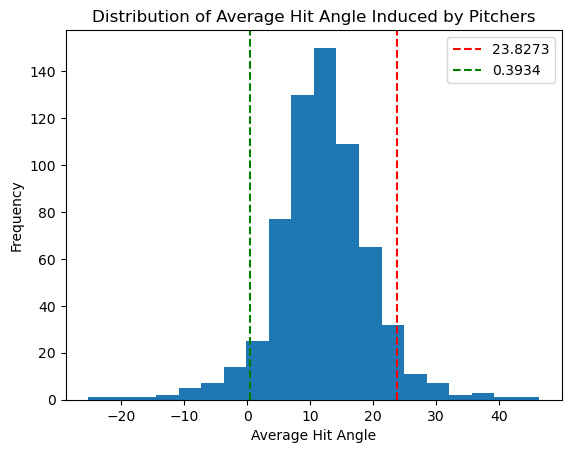

,vangle_A
pitcher,
4,25.403166
6,25.877280
34,-0.260034
70,-12.995399
77,23.829324
...,...
608,-9.827131
621,25.134632
623,-13.039971


In [48]:
#Angle

pitcher_mean_angle_A = final_data_A.groupby('pitcher')['vangle_A'].mean()

threshold_high_angle_A = round( pitcher_mean_angle_A.quantile(0.95), 4)
threshold_low_angle_A = round( pitcher_mean_angle_A.quantile(0.05), 4)
outstanding_pitchers_A = pitcher_mean_angle_A[(pitcher_mean_angle_A >= threshold_high_angle_A) | (pitcher_mean_angle_A <= threshold_low_angle_A)]


plt.hist(pitcher_mean_angle_A, bins=20)
plt.xlabel("Average Hit Angle")
plt.ylabel("Frequency")
plt.title("Distribution of Average Hit Angle Induced by Pitchers")
plt.axvline(threshold_high_angle_A, color='r', linestyle='--', label = threshold_high_angle_A)
plt.axvline(threshold_low_angle_A, color='g', linestyle='--', label= threshold_low_angle_A)
plt.legend()
plt.show()

outstanding_pitchers_A = outstanding_pitchers_A.to_frame()
outstanding_pitchers_A

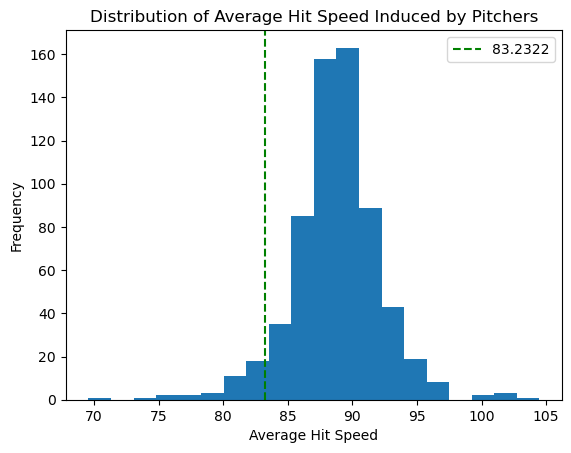

,speed_A
pitcher,
54,80.402931
57,79.608232
70,75.890516
130,82.117250
135,77.919922
149,82.011339
155,80.990176
176,82.457782
189,81.389325


In [57]:
#Speed

pitcher_mean_speed_A = final_data_A.groupby('pitcher')['speed_A'].mean()

threshold_low_speed_A = round( pitcher_mean_speed_A.quantile(0.05), 4)
low_speed_pitchers_A = pitcher_mean_speed_A[ pitcher_mean_speed_A <= threshold_low_speed_A ]


plt.hist(pitcher_mean_speed_A, bins=20)
plt.xlabel("Average Hit Speed")
plt.ylabel("Frequency")
plt.title("Distribution of Average Hit Speed Induced by Pitchers")
plt.axvline(threshold_low_speed_A, color='g', linestyle='--', label= threshold_low_speed_A)
plt.legend()
plt.show()

low_speed_pitchers_A = low_speed_pitchers_A.to_frame()
low_speed_pitchers_A

Measure B

In [50]:
pitcher_counts_B = data_clean_B_filtered['pitcher'].value_counts()
pitcher_atleast30_B = pitcher_counts_B[pitcher_counts_B >= 30].index

# Filter the original DataFrame for these batters
data_clean_B_filtered_2 = data_clean_B_filtered[data_clean_B_filtered['pitcher'].isin(pitcher_atleast30_B)]
data_clean_B_filtered_2

,batter,pitcher,hittype,speed_B,vangle_B,abs_angle_diff
0,393,405,ground_ball,103.842569,3.164307,1.020907
2,448,518,line_drive,97.846002,11.658800,9.515400
3,140,518,fly_ball,59.389741,32.798274,30.654874
5,401,518,ground_ball,78.508931,-7.471214,9.614614
6,184,405,ground_ball,62.273449,-12.718385,14.861785
...,...,...,...,...,...,...
73357,95,181,line_drive,101.552784,17.775527,15.632127
73358,498,181,fly_ball,88.054001,43.852831,41.709431
73359,304,181,ground_ball,99.693783,-3.420569,5.563969
73366,172,510,line_drive,87.061321,17.224508,15.081108


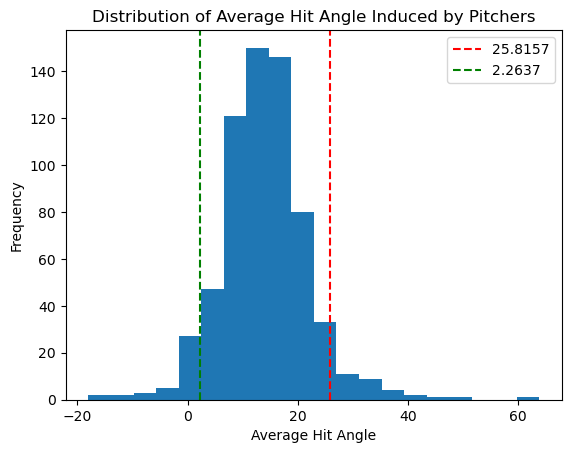

,vangle_B
pitcher,
4,26.113551
24,-0.196539
67,38.838423
70,-6.420569
77,28.873292
...,...
630,0.616050
632,2.254765
636,-1.727934


In [51]:
#Angle

pitcher_mean_angle_B = final_data_B.groupby('pitcher')['vangle_B'].mean()

threshold_high_angle_B = round( pitcher_mean_angle_B.quantile(0.95), 4)
threshold_low_angle_B = round( pitcher_mean_angle_B.quantile(0.05), 4)
outstanding_pitchers_B = pitcher_mean_angle_B[(pitcher_mean_angle_B >= threshold_high_angle_B) | (pitcher_mean_angle_B <= threshold_low_angle_B)]


plt.hist(pitcher_mean_angle_B, bins=20)
plt.xlabel("Average Hit Angle")
plt.ylabel("Frequency")
plt.title("Distribution of Average Hit Angle Induced by Pitchers")
plt.axvline(threshold_high_angle_B, color='r', linestyle='--', label = threshold_high_angle_B)
plt.axvline(threshold_low_angle_B, color='g', linestyle='--', label= threshold_low_angle_B)
plt.legend()
plt.show()

outstanding_pitchers_B = outstanding_pitchers_B.to_frame()
outstanding_pitchers_B

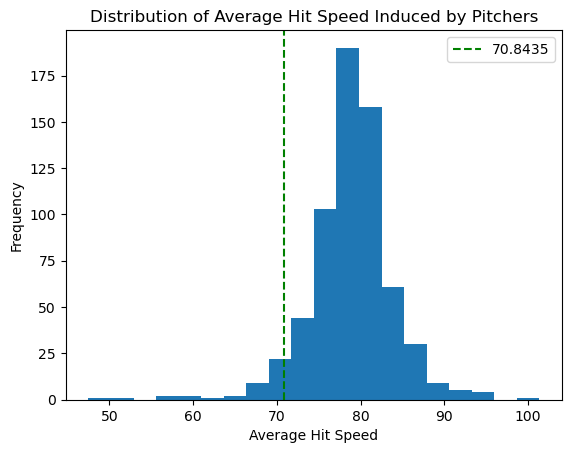

,speed_B
pitcher,
24,69.396103
51,70.611257
70,52.887476
135,70.585578
175,68.122492
190,67.108023
205,69.561652
207,68.968677
219,47.504040


In [58]:
#Speed

pitcher_mean_speed_B = final_data_B.groupby('pitcher')['speed_B'].mean()

threshold_low_speed_B = round( pitcher_mean_speed_B.quantile(0.05), 4)
low_speed_pitchers_B = pitcher_mean_speed_B[ pitcher_mean_speed_B <= threshold_low_speed_B ]


plt.hist(pitcher_mean_speed_B, bins=20)
plt.xlabel("Average Hit Speed")
plt.ylabel("Frequency")
plt.title("Distribution of Average Hit Speed Induced by Pitchers")
plt.axvline(threshold_low_speed_B, color='g', linestyle='--', label= threshold_low_speed_B)
plt.legend()
plt.show()

low_speed_pitchers_B = low_speed_pitchers_B.to_frame()
low_speed_pitchers_B